<a href="https://colab.research.google.com/github/mitkrieg/Tensor-Puzzles/blob/main/Tensor%20Puzzlers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensor Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp) (with Marcos Treviso)





When learning a tensor programming language like PyTorch or Numpy it
is tempting to rely on the standard library (or more honestly
StackOverflow) to find a magic function for everything.  But in
practice, the tensor language is extremely expressive, and you can
do most things from first principles and clever use of broadcasting.



This is a collection of 21 tensor puzzles. Like chess puzzles these are
not meant to simulate the complexity of a real program, but to practice
in a simplified environment. Each puzzle asks you to reimplement one
function in the NumPy standard library without magic.


I recommend running in Colab. Click here and copy the notebook to get start.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/Tensor-Puzzles/blob/main/Tensor%20Puzzlers.ipynb)

In [1]:
!pip install -qqq torchtyping hypothesis pytest git+https://github.com/chalk-diagrams/chalk
!wget -q https://github.com/srush/Tensor-Puzzles/raw/main/lib.py

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.1/538.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
from lib import draw_examples, make_test, run_test
import torch
import numpy as np
from torchtyping import TensorType as TT
tensor = torch.tensor

## Rules

1. These puzzles are about *broadcasting*. Know this rule.

![](https://pbs.twimg.com/media/FQywor0WYAssn7Y?format=png&name=large)

2. Each puzzle needs to be solved in 1 line (<80 columns) of code.
3. You are allowed @, arithmetic, comparison, `shape`, any indexing (e.g. `a[:j], a[:, None], a[arange(10)]`), and previous puzzle functions.
4. You are *not allowed* anything else. No `view`, `sum`, `take`, `squeeze`, `tensor`.

5. You can start with these two functions:

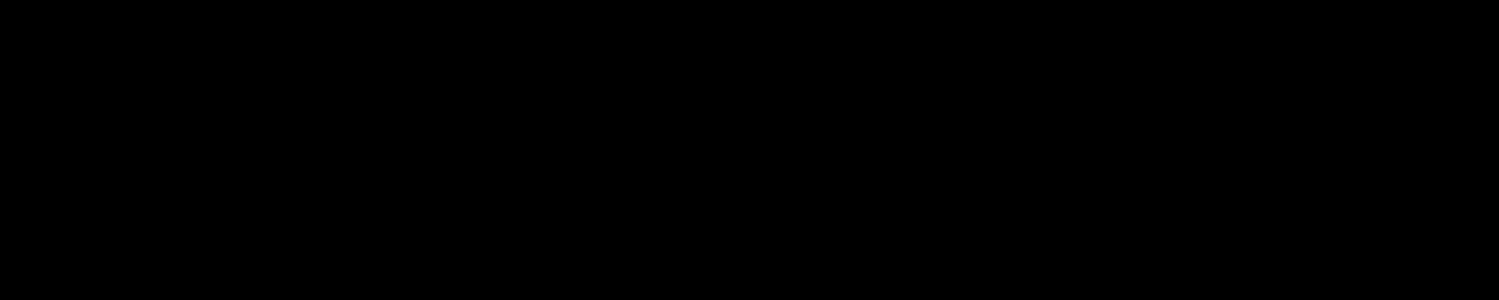

In [3]:
def arange(i: int):
    """
    Use this function to replace a for-loop.

    Explaination: raw python
    """
    return torch.tensor(range(i))

draw_examples("arange", [{"" : arange(i)} for i in [5, 3, 9]])

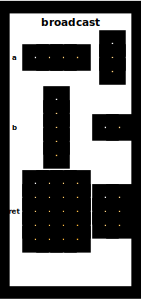

In [4]:
# Example of broadcasting.
# Explaination: tensor a gets broadcasted downward, tensor b gets broadcasted rightward
# the sum therefore is a matrix where the indicies of the entry in the matrix is the sum of
# the corresponding matricies in the addends
examples = [(arange(4), arange(5)[:, None]) ,
            (arange(3)[:, None], arange(2))]
draw_examples("broadcast", [{"a": a, "b":b, "ret": a + b} for a, b in examples])

In [5]:
arange(4) + arange(4)[:, None]

tensor([[0, 1, 2, 3],
        [1, 2, 3, 4],
        [2, 3, 4, 5],
        [3, 4, 5, 6]])

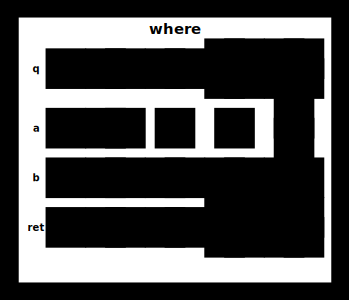

In [6]:
def where(q, a, b):
    "Use this function to replace an if-statement."
    return (q * a) + (~q) * b

# In diagrams, orange is positive/True, white is zero/False, and blue is negative.

examples = [(tensor([False]), tensor([10]), tensor([0])),
            (tensor([False, True]), tensor([1, 1]), tensor([-10, 0])),
            (tensor([False, True]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([[0], [10]]), tensor([-10, 0])),
           ]
draw_examples("where", [{"q": q, "a":a, "b":b, "ret": where(q, a, b)} for q, a, b in examples])

## Puzzle 1 - ones

Compute [ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) - the vector of all ones.

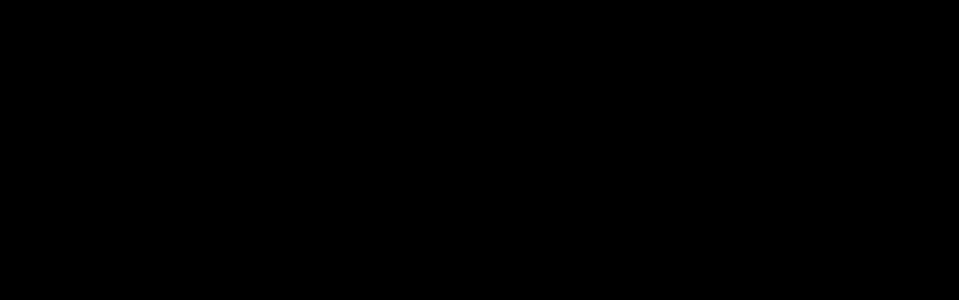

In [7]:
def ones_spec(out):
    for i in range(len(out)):
        out[i] = 1

def ones(i: int) -> TT["i"]:
    """
    Makes an array of ones of len i
    Explaination: arange(i) > -1 is always true, so this will always return 1
    """
    # return tensor([1] * i)
    return where(arange(i) > -1, 1, 0)

test_ones = make_test("one", ones, ones_spec, add_sizes=["i"])

In [8]:
run_test(test_ones)

Correct!


## Puzzle 2 - sum

Compute [sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) - the sum of a vector.

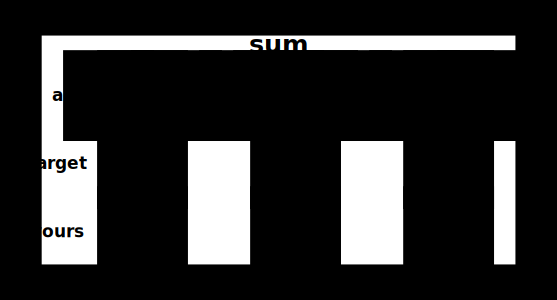

In [9]:
def sum_spec(a, out):
    out[0] = 0
    for i in range(len(a)):
        out[0] += a[i]

def sum(a: TT["i"]) -> TT[1]:
    """
    Sums a vector.
    Explaination: a matmul between a vector of ones and the vector multiplies each element
    by one and then sums the vector together. [None] is added to keep it a vector instead of
    a scalar
    """
    return ones(a.shape[0]) @ a[:,None]


test_sum = make_test("sum", sum, sum_spec)

In [10]:
run_test(test_sum)

Correct!


## Puzzle 3 - outer

Compute [outer](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) - the outer product of two vectors.

In [11]:
a = tensor([1,2,3,4])
b = tensor([2,2,2,1])

a * b[:, None]

tensor([[2, 4, 6, 8],
        [2, 4, 6, 8],
        [2, 4, 6, 8],
        [1, 2, 3, 4]])

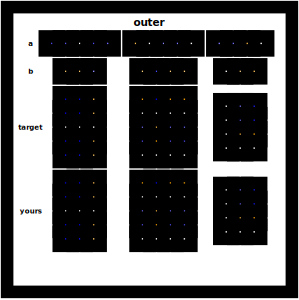

In [12]:
def outer_spec(a, b, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            out[i][j] = a[i] * b[j]

def outer(a: TT["i"], b: TT["j"]) -> TT["i", "j"]:
    return a[:, None] * b

test_outer = make_test("outer", outer, outer_spec)

In [13]:
run_test(test_outer)

Correct!


## Puzzle 4 - diag

Compute [diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) - the diagonal vector of a square matrix.

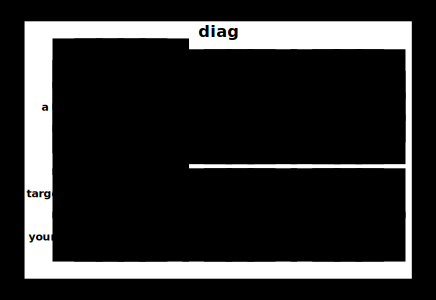

In [14]:
def diag_spec(a, out):
    for i in range(len(a)):
        out[i] = a[i][i]

def diag(a: TT["i", "i"]) -> TT["i"]:
    """
    Returns the diagnal as a vector
    Explaination: use arange to make a mask where the idicies are eqaual (aka diagnoal)
    multiply by a elementwise to get the diag values and sum to reduce to a vector
    [0] removes the extra dim from (a.shape[0], 1) to (a.shape[0],)
    """
    # return sum((arange(a.shape[0]) == arange(a.shape[1])[:,None]) * a)[0]

    # alternative: index along the diagnal -> this zips together the tensor passed into the first dim and the second dim to
    # get indicies at eached zipped pair
    return a[arange(a.shape[0]), arange(a.shape[0])]


test_diag = make_test("diag", diag, diag_spec)

In [15]:
run_test(test_diag)

Correct!


## Puzzle 5 - eye

Compute [eye](https://numpy.org/doc/stable/reference/generated/numpy.eye.html) - the identity matrix.

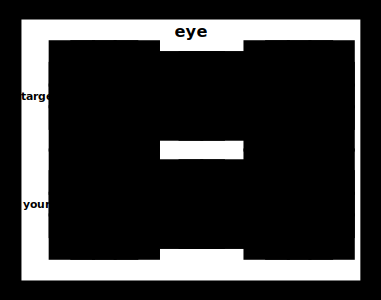

In [16]:
def eye_spec(out):
    for i in range(len(out)):
        out[i][i] = 1

def eye(j: int) -> TT["j", "j"]:
    """
    Creates the identity matrix
    Explaination: create the matrix of all 1s and all zeros, find where the aranges are equal to eachother
    """
    # return where((arange(j) == arange(j)[:,None]), 1, 0)

    # Boolean Version:
    # using equality between a row arange and a column arange returns the diagnol
    # because it is the only place where the indicies are equal once broadcasted. the 1 returns an in instead of a bool
    return 1 * (arange(j)[:,None] == arange(j)[None,:])




test_eye = make_test("eye", eye, eye_spec, add_sizes=["j"])

In [17]:
run_test(test_eye)

Correct!


## Puzzle 6 - triu

Compute [triu](https://numpy.org/doc/stable/reference/generated/numpy.triu.html) - the upper triangular matrix.

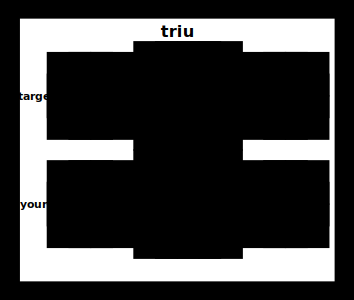

In [18]:
def triu_spec(out):
    for i in range(len(out)):
        for j in range(len(out)):
            if i <= j:
                out[i][j] = 1
            else:
                out[i][j] = 0

def triu(j: int) -> TT["j", "j"]:
    return 1 * (arange(j)[:,None] <= arange(j)[None,:])


test_triu = make_test("triu", triu, triu_spec, add_sizes=["j"])

In [19]:
run_test(test_triu)

Correct!


## Puzzle 7 - cumsum

Compute [cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) - the cumulative sum.

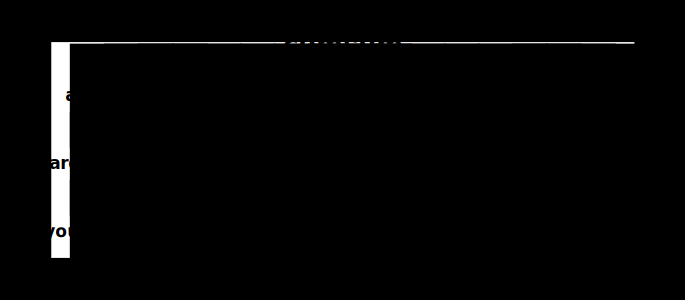

In [20]:
def cumsum_spec(a, out):
    total = 0
    for i in range(len(out)):
        out[i] = total + a[i]
        total += a[i]

def cumsum(a: TT["i"]) -> TT["i"]:
    """
    Returns a vector of the cumulative sum
    Explaination: transpose to a col vector and use triu to create all sums the make up a matrix with each col being one step in the cum sum
    the use ones to reduce the matrix to a single dim vector.
    """
    return ones(a.shape[0]) @ (a[:,None] * triu(a.shape[0]))

test_cumsum = make_test("cumsum", cumsum, cumsum_spec)

In [21]:
a = tensor([-4,  4, -1,  2])[:,None]

In [22]:
(a * triu(4))

tensor([[-4, -4, -4, -4],
        [ 0,  4,  4,  4],
        [ 0,  0, -1, -1],
        [ 0,  0,  0,  2]])

In [23]:
ones(4) @ (a * triu(4))

tensor([-4,  0, -1,  1])

In [24]:
run_test(test_cumsum)

Correct!


## Puzzle 8 - diff

Compute [diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) - the running difference.

In [25]:
eye(5) - ((arange(5)[:, None] - arange(5)[None, :] == 1) * 1)

tensor([[ 1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0],
        [ 0, -1,  1,  0,  0],
        [ 0,  0, -1,  1,  0],
        [ 0,  0,  0, -1,  1]])

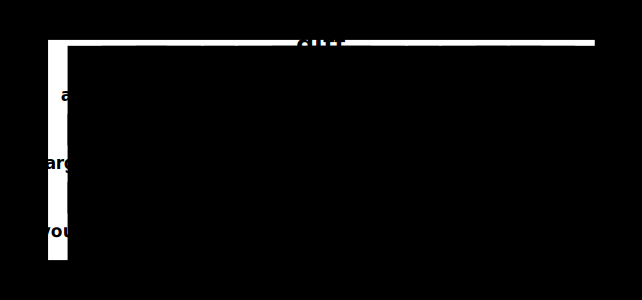

In [26]:
def diff_spec(a, out):
    out[0] = a[0]
    for i in range(1, len(out)):
        out[i] = a[i] - a[i - 1]

def diff(a: TT["i"], i: int) -> TT["i"]:
    """
    Computes the running diff on a with a len of i for window size 1
    """

    # Using matricies: Create a matrix like the below by subtracting a sub diagnal matrix from
    # the identity matrix. so it looks like this
    # tensor([[ 1,  0,  0,  0,  0],
    #         [-1,  1,  0,  0,  0],
    #         [ 0, -1,  1,  0,  0],
    #         [ 0,  0, -1,  1,  0],
    #         [ 0,  0,  0, -1,  1]])
    # mat mul this matrix with the input vector
    # return (eye(i) - ((arange(i)[:, None] - arange(i)[None, :] == 1) * 1  ) ) @ a

    # Using where: subtract from a 0 if its the first index, otherwise subtract the index before it
    return a - where(arange(i) != 0, a[arange(i) - 1], 0)

test_diff = make_test("diff", diff, diff_spec, add_sizes=["i"])

In [27]:
run_test(test_diff)

Correct!


## Puzzle 9 - vstack

Compute [vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) - the matrix of two vectors

In [28]:
arange(2)[:,None] != ones(a.shape[0])

tensor([[ True,  True,  True,  True],
        [False, False, False, False]])

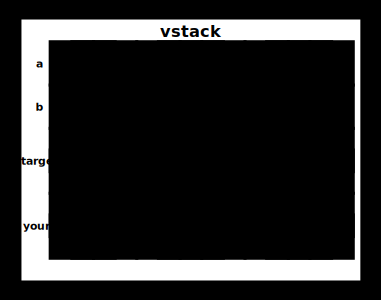

In [29]:
def vstack_spec(a, b, out):
    for i in range(len(out[0])):
        out[0][i] = a[i]
        out[1][i] = b[i]

def vstack(a: TT["i"], b: TT["i"]) -> TT[2, "i"]:
    """
    Vertically stack two arrays
    Explaination: arrange the size you need to make the final shape. Use inequality broadcasting
    to create a rows of all Trues in the first rows and all falses in the second row. Then use where to insert the correct vector
    """
    return where(arange(2)[:,None] != ones(a.shape[0]), a, b)


test_vstack = make_test("vstack", vstack, vstack_spec)

In [30]:
run_test(test_vstack)

Correct!


## Puzzle 10 - roll

Compute [roll](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) - the vector shifted 1 circular position.

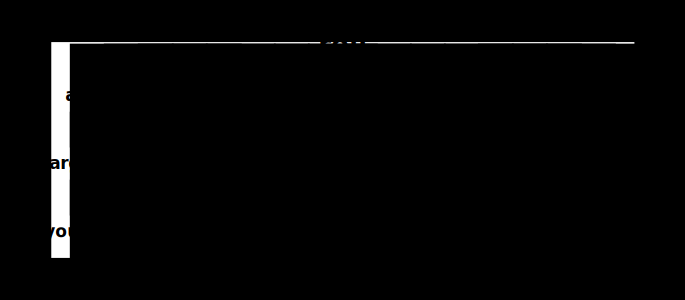

In [31]:
def roll_spec(a, out):
    for i in range(len(out)):
        if i + 1 < len(out):
            out[i] = a[i + 1]
        else:
            out[i] = a[i + 1 - len(out)]

def roll(a: TT["i"], i: int) -> TT["i"]:
    """
    Move all elements one to the left.
    if we subtract the entire shape we end up with the same array. Add 1 to stop one short of a full cycle
    """
    # return a[arange(a.shape[0]) - a.shape[0] + 1]

    # alternative: use mod to cycle trough
    return a[(arange(i) + 1) % i]


test_roll = make_test("roll", roll, roll_spec, add_sizes=["i"])

In [32]:
arange(5) == 0

tensor([ True, False, False, False, False])

In [33]:
run_test(test_roll)

Correct!


## Puzzle 11 - flip

Compute [flip](https://numpy.org/doc/stable/reference/generated/numpy.flip.html) - the reversed vector

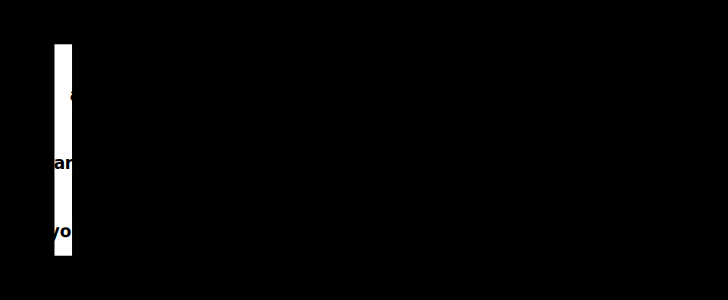

In [34]:
def flip_spec(a, out):
    for i in range(len(out)):
        out[i] = a[len(out) - i - 1]

def flip(a: TT["i"], i: int) -> TT["i"]:
    return a[(arange(i) + 1) * -1]
    # alternative
    # return a[i - arange(i) - 1]


test_flip = make_test("flip", flip, flip_spec, add_sizes=["i"])

In [35]:
5 - arange(5) - 1

tensor([4, 3, 2, 1, 0])

In [36]:
run_test(test_flip)

Correct!


## Puzzle 12 - compress


Compute [compress](https://numpy.org/doc/stable/reference/generated/numpy.compress.html) - keep only masked entries (left-aligned).

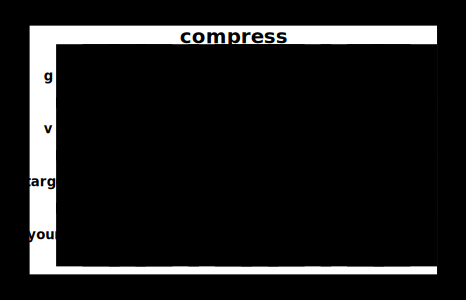

In [37]:
def compress_spec(g, v, out):
    j = 0
    for i in range(len(g)):
        if g[i]:
            out[j] = v[i]
            j += 1

def compress(g: TT["i", bool], v: TT["i"], i:int) -> TT["i"]:
    """
    based on the condition g mask the array v and then left align all of its values and then pad the remaining part of the vector
    Explaination: cumsum gives us the entries where a value is present. if we subtract 1 we get the positions in the final vector where these values end up
    Then we build a matrix that maps from original position on the rows to out put position on the columns by using broadcasting. The where clause sets all other values
    in the matrix to zero. Then matmul with the orignal vector to get the output
    """
    return v @ where(g[:,None], arange(i) == (cumsum(1 * g) - 1)[:,None], 0)


test_compress = make_test("compress", compress, compress_spec, add_sizes=["i"])

In [38]:
v = tensor([1,2,3,4,5])
g = tensor([False, False, True, False, True])

In [39]:
cumsum(1 * g) -1

tensor([-1, -1,  0,  0,  1])

In [40]:
where(g[:,None], arange(5) == (cumsum(1 * g) - 1)[:,None], 0)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [41]:
g[:,None]

tensor([[False],
        [False],
        [ True],
        [False],
        [ True]])

In [42]:
arange(5) == (cumsum(1 * g) - 1)[:,None]

tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False,  True, False, False, False]])

In [43]:
run_test(test_compress)

Correct!


## Puzzle 13 - pad_to


Compute pad_to - eliminate or add 0s to change size of vector.

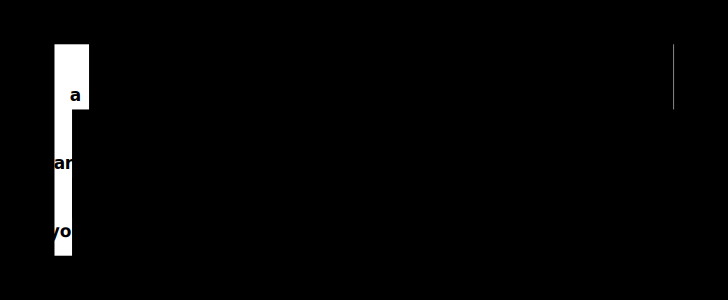

In [44]:
def pad_to_spec(a, out):
    for i in range(min(len(out), len(a))):
        out[i] = a[i]


def pad_to(a: TT["i"], i: int, j: int) -> TT["j"]:
    """Change the size of the vector from i to j by either dropping elements or adding zeros
    Explaination: create an pseudo idenity matrix that has 1s along the diagnal but isn't square so that it adds zeros
    if i < j (extra cols) or truncates the array because i > j (too few cols). then matmul with the original array
    """
    return a @ (1 * (arange(i)[:,None] == arange(j)))


test_pad_to = make_test("pad_to", pad_to, pad_to_spec, add_sizes=["i", "j"])

In [45]:
(1 * (arange(5)[:,None] == arange(7)))

tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]])

In [46]:
(1 * (arange(6)[:,None] == arange(4)))

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [47]:
run_test(test_pad_to)

Correct!


## Puzzle 14 - sequence_mask


Compute [sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) - pad out to length per batch.

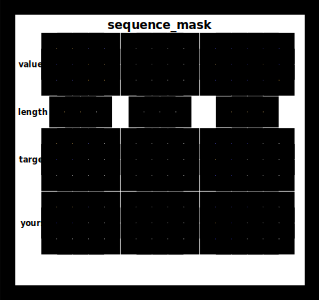

In [48]:
def sequence_mask_spec(values, length, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            if j < length[i]:
                out[i][j] = values[i][j]
            else:
                out[i][j] = 0

def sequence_mask(values: TT["i", "j"], length: TT["i", int]) -> TT["i", "j"]:
    """
    Per row (aka batch), select the first x number of elements based on the equivalent index in length
    Explaination: create a matrix where the value is true for all elements before the corresponding index value in length. then use where
    """
    return where(arange(values.shape[-1]) < length[:,None], values, 0)


def constraint_set_length(d):
    d["length"] = d["length"] % d["values"].shape[1]
    return d


test_sequence = make_test("sequence_mask",
    sequence_mask, sequence_mask_spec, constraint=constraint_set_length
)

In [49]:
v = tensor([
    [1,2,3,4],
    [5,6,7,8],
    [9,10,11,12]
])

length = tensor([1,2, 4])

In [50]:
arange(v.shape[-1]) < length[:,None]

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True,  True]])

In [51]:
where(arange(v.shape[-1]) < length[:,None], v, 0)

tensor([[ 1,  0,  0,  0],
        [ 5,  6,  0,  0],
        [ 9, 10, 11, 12]])

In [52]:
run_test(test_sequence)

Correct!


## Puzzle 15 - bincount

Compute [bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) - count number of times an entry was seen.

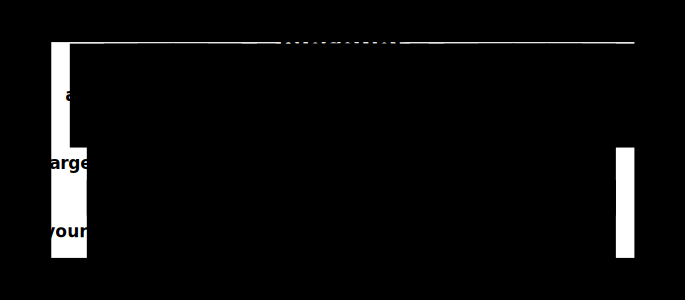

In [53]:
def bincount_spec(a, out):
    for i in range(len(a)):
        out[a[i]] += 1

def bincount(a: TT["i"], j: int) -> TT["j"]:
    """
    Counts the number of times an entry is seen
    explaination: Build an identity matrix of size j (max possible value in the array)
    then index the identity matrix by the array a. This effectively asks for give me row x in the idenity matrix
    for the value x of the element in a. It effectively one hot encodes a. Then we can just sum the OHEed values to get the count.
    """
    return ones(a.shape[0]) @ eye(j)[a]


def constraint_set_max(d):
    d["a"] = d["a"] % d["return"].shape[0]
    return d


test_bincount = make_test("bincount",
    bincount, bincount_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [54]:
a = tensor([1,2,2,2,2,2,2,1,0,2,2,2,2,2,2,2, 10])
eye(a.shape[0])[a]

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 

In [55]:
ones(a.shape[0]) @ eye(a.shape[0])[a]

tensor([ 1,  2, 13,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0])

In [56]:
run_test(test_bincount)

Correct!


## Puzzle 16 - scatter_add

Compute [scatter_add](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/add.html) - add together values that link to the same location.

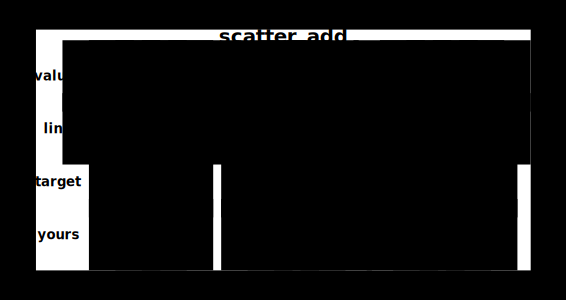

In [57]:
def scatter_add_spec(values, link, out):
    for j in range(len(values)):
        out[link[j]] += values[j]

def scatter_add(values: TT["i"], link: TT["i"], j: int) -> TT["j"]:
    """Add together elements in the values array based on what output index they are assigned in the link array
    Explaination: eye(j)[link] gives you a matrix of element values by what index they should sum to. Multuply the values and then sum using ones
    """
    return ones(values.shape[0]) @ (eye(j)[link] * values[:,None])
    # alternative
    return values @ eye(j)[link]


def constraint_set_max(d):
    d["link"] = d["link"] % d["return"].shape[0]
    return d


test_scatter_add = make_test("scatter_add",
    scatter_add, scatter_add_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [58]:
v = tensor([1,2,3,4,5,6,7,8,9,10])
link = tensor([0,0,1,2,0,1,3,2,3,0])

In [59]:
eye(4)[link]

tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]])

In [60]:
(eye(4)[link] * v[:,None])

tensor([[ 1,  0,  0,  0],
        [ 2,  0,  0,  0],
        [ 0,  3,  0,  0],
        [ 0,  0,  4,  0],
        [ 5,  0,  0,  0],
        [ 0,  6,  0,  0],
        [ 0,  0,  0,  7],
        [ 0,  0,  8,  0],
        [ 0,  0,  0,  9],
        [10,  0,  0,  0]])

In [61]:
ones(10) @ (eye(4)[link] * v[:,None])

tensor([18,  9, 12, 16])

In [62]:
run_test(test_scatter_add)

Correct!


## Puzzle 17 - flatten

Compute [flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html)

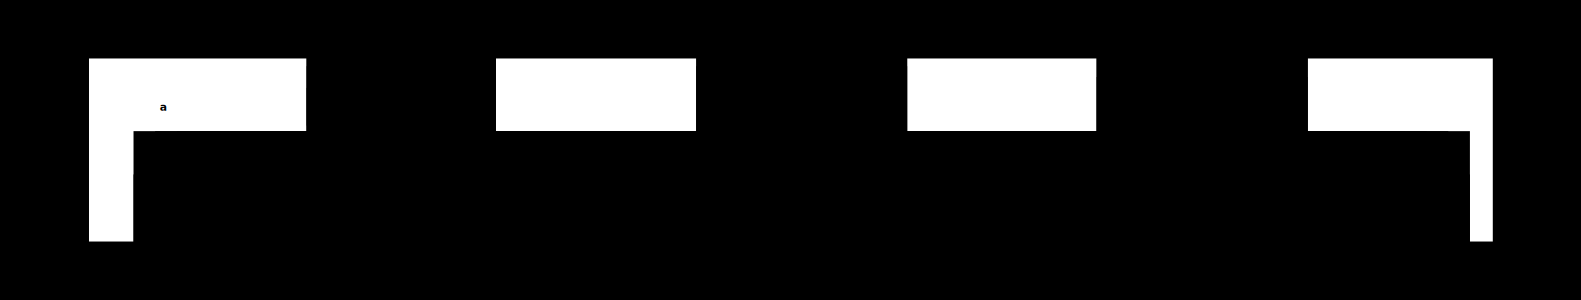

In [63]:
def flatten_spec(a, out):
    k = 0
    for i in range(len(a)):
        for j in range(len(a[0])):
            out[k] = a[i][j]
            k += 1

def flatten(a: TT["i", "j"], i:int, j:int) -> TT["i * j"]:
    return a[arange(i * j) // j, arange(i * j) % j]

test_flatten = make_test("flatten", flatten, flatten_spec, add_sizes=["i", "j"])

In [64]:
a = tensor([[1,2,3,4,4],
           [0,9,8,1,2],
           [3,3,3,3,3]])

In [65]:
arange(3*5) // 5

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [66]:
arange(3*5) % 5

tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

In [67]:
a[arange(3*5) // 5, arange(3*5) % 5]

tensor([1, 2, 3, 4, 4, 0, 9, 8, 1, 2, 3, 3, 3, 3, 3])

In [68]:
run_test(test_flatten)

Correct!


## Puzzle 18 - linspace

Compute [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)

/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))


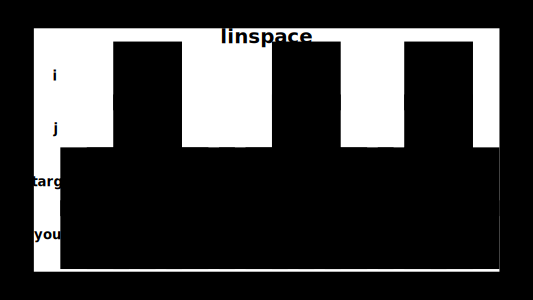

In [69]:
def linspace_spec(i, j, out):
    for k in range(len(out)):
        out[k] = float(i + (j - i) * k / max(1, len(out) - 1))

def linspace(i: TT[1], j: TT[1], n: int) -> TT["n", float]:
    # alternative
    return ((j-i)/max(1,n-1)) * arange(n) + i
    # return (i+ (j - 1) * arange(n) / max(1,n-1))

test_linspace = make_test("linspace", linspace, linspace_spec, add_sizes=["n"])

In [70]:
i = 10
j = 30
n = 5

In [71]:
((j-i)/(n-1)) * arange(n) + i

tensor([10., 15., 20., 25., 30.])

In [72]:
run_test(test_linspace)

/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conver

Correct!


/tmp/ipython-input-330948822.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))


## Puzzle 19 - heaviside

Compute [heaviside](https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html)

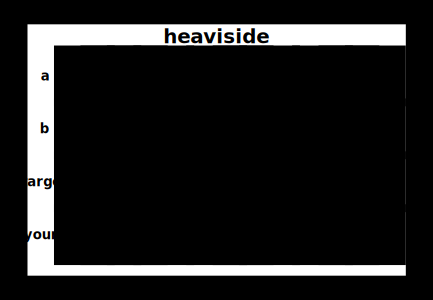

In [81]:
def heaviside_spec(a, b, out):
    for k in range(len(out)):
        if a[k] == 0:
            out[k] = b[k]
        else:
            out[k] = int(a[k] > 0)

def heaviside(a: TT["i"], b: TT["i"]) -> TT["i"]:
    return where(a == 0, b, a> 0 *1)

test_heaviside = make_test("heaviside", heaviside, heaviside_spec)

In [77]:
a = tensor([-2,4,5,0,6,-1,0])
b = tensor([ 3,4,8,1,3, 4, 5])

In [78]:
where(a == 0, b, a> 0 *1)

tensor([0, 1, 1, 1, 1, 0, 5])

In [82]:
run_test(test_heaviside)

Correct!


## Puzzle 20 - repeat (1d)

Compute [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html)

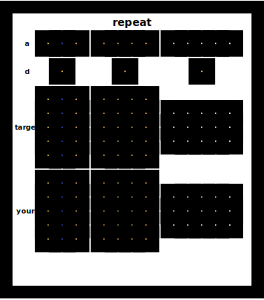

In [87]:
def repeat_spec(a, d, out):
    for i in range(d[0]):
        for k in range(len(a)):
            out[i][k] = a[k]

def constraint_set(d):
    d["d"][0] = d["return"].shape[0]
    return d


def repeat(a: TT["i"], d: TT[1]) -> TT["d", "i"]:
    return ones(d)[:,None] * a

test_repeat = make_test("repeat", repeat, repeat_spec, constraint=constraint_set)




In [83]:
a = tensor([3,2,5,1,3])


In [88]:
run_test(test_repeat)

Correct!


## Puzzle 21 - bucketize
Compute [bucketize](https://pytorch.org/docs/stable/generated/torch.bucketize.html)

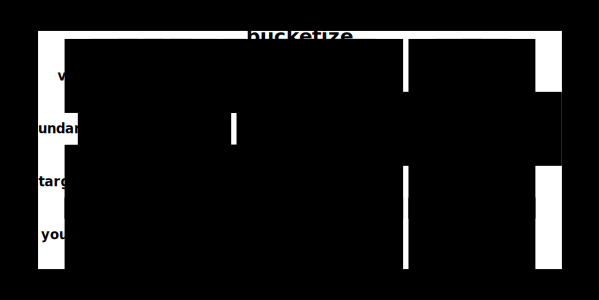

In [127]:
def bucketize_spec(v, boundaries, out):
    for i, val in enumerate(v):
        out[i] = 0
        for j in range(len(boundaries)-1):
            if val >= boundaries[j]:
                out[i] = j + 1
        if val >= boundaries[-1]:
            out[i] = len(boundaries)


def constraint_set(d):
    d["boundaries"] = np.abs(d["boundaries"]).cumsum()
    return d


def bucketize(v: TT["i"], boundaries: TT["j"]) -> TT["i"]:
    return ((v[:,None] >= boundaries) * 1) @ ones(boundaries.shape[0])

test_bucketize = make_test("bucketize", bucketize, bucketize_spec,
                           constraint=constraint_set)


#
# # Speed Run Mode!
#
# What is the smallest you can make each of these?

In [129]:
run_test(test_bucketize)

Correct!


In [123]:
v = tensor([1,5,1,10,100,4,43,24,25,25,25,25,25])
b = tensor([0,3,10,20,50,200])

In [ ]:
diff()

In [126]:
(v[:,None] >= b) * 1

tensor([[1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0]])

In [119]:
v.shape[0]

10

In [ ]:
pad_to()

In [130]:
import inspect
fns = (ones, sum, outer, diag, eye, triu, cumsum, diff, vstack, roll, flip,
       compress, pad_to, sequence_mask, bincount, scatter_add)

for fn in fns:
    lines = [l for l in inspect.getsource(fn).split("\n") if not l.strip().startswith("#")]

    if len(lines) > 3:
        print(fn.__name__, len(lines[2]), "(more than 1 line)")
    else:
        print(fn.__name__, len(lines[1]))

ones 35 (more than 1 line)
sum 18 (more than 1 line)
outer 25
diag 35 (more than 1 line)
eye 31 (more than 1 line)
triu 55
cumsum 42 (more than 1 line)
diff 68 (more than 1 line)
vstack 31 (more than 1 line)
roll 39 (more than 1 line)
flip 34
compress 129 (more than 1 line)
pad_to 118 (more than 1 line)
sequence_mask 102 (more than 1 line)
bincount 47 (more than 1 line)
scatter_add 145 (more than 1 line)
